# Week 5 - Natural Language Processing (NLP)

In this week's exercise, we will apply neural networks to a new type of data - text. You will also pick your own corpus of text to play with.  **But first, some definitions** (there's a lot of new jargon in 'NLP'):
* *Corpus*: The set of all text documents you want to work on
* *Document*: An individual unit of text in your corpus

Below are some **examples of corpora** to get you thinking:

* Corpus of 100,000 IMDB reviews, where each document is an individual review
* Corpus of 20 English novels, where each document is an individual novel
* Corpus of one Malay novel, where each document is a chapter

You can **browse for a corpus in the below links** (if you don't already have one in mind):

* https://github.com/niderhoff/nlp-datasets
* https://www.gutenberg.org/catalog/

If this is your first time working with text, it's probably easier to deal with a corpus of many short documents - for example the IMDB review dataset, which is linked below in Chapter 2.  Play around with several corpora over the course of week, and work with something that interests you. Remember text doesn't have to be English (try other languages), or even a natural language (try code or musical notation)!

**Key learning resources** for the week:
* https://web.stanford.edu/~jurafsky/slp3/ - legendary textbook introducing key theory and concepts of working with text, up to deep learning methods
* http://web.stanford.edu/class/cs224n/ - great course that introduces theory and concepts of text processing in the context of deep learning (can read class notes / assignments and skip videos if you are short on time) 
* https://course.fast.ai/index.html - fast.ai's introduction to deep learning (you'll have to pick out the bits about text and RNNs) is an efficient and effective way of tackling the topic
* https://www.datacamp.com/courses/natural-language-processing-fundamentals-in-python - very hands on datacamp course that will let you practice using existing tools for NLP tasks

Some **additional tools below** that can help in NLP (if you haven't found them already):
* scikit-learn has a handy set of features for NLP
* https://spacy.io/ - commercially oriented python package for NLP
* https://www.nltk.org/ - slightly more academic oriented python package for NLP 

## Imports

In [1]:
import numpy as np  # a conventional alias
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from src.preprocess import getFileNames
from scipy.cluster import  hierarchy
from scipy.cluster.hierarchy import linkage,dendrogram,cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.linear_model import LogisticRegression

# Chapter 1: How do we turn text into data we can use?

### Convert your corpus into bags of words

We can't apply any of the techniques we have learned over the past few weeks directly on raw text.  Therefore, our first task is to convert our corpus into numbers.  The simplest way to do this is to use a **bag of words**. You can see some examples of this here: https://liferay.de.dariah.eu/tatom/index.html.

Once you understand the concept, convert your corpus and documents into bags of words below:

- Using the IMDB movies reviews
- Unsup dataset is used

In [17]:
# mypath='/home/hanifa/workspace/AIAP/AIAP_Week5/aclImdb/train/tt'
# mypath='/home/hanifa/workspace/AIAP/AIAP_Week5/aclImdb/unsup/'
mypath='/home/jupyter/AIAP_Week5/aclImdb/unsup'
filenames=getFileNames(mypath)

In [18]:
def checkVectorizer(dtm):
    a=dtm.sum(axis=0)
    a.sort(axis=0)
    print(a)

- Was having memory errors loading all the unsup data, thus just took a sample of 7K.
- Stopwords were iteratively added.

In [22]:
from sklearn.feature_extraction import text 
my_additional_stop_words=['br','film','movie']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

vectorizer = CountVectorizer(input='filename',stop_words=stop_words,
                             token_pattern='[a-zA-Z]{3,}',lowercase=True)

    
# vectorizer = CountVectorizer(input='filename',stop_words='english')'
dtm = vectorizer.fit_transform(filenames)  # a sparse matrix 
vocab = vectorizer.get_feature_names()

# type(dtm)                                         
dtm = dtm.toarray()  # convert to a regular array 
vocab = np.array(vocab)

In [23]:
# checkVectorizer(dtm)
dtm.shape

(5556, 36082)

### Show us your bags

Show and explain what one of your documents looks like as a bag of words below.  What are the advantages and disadvantages of encoding text as bags of words?

- The column represents the words and the rows the document itself. 
- By summing up the column, we can total frequency across all documents

__Bag of Words Representation__

In [24]:
df=pd.DataFrame(dtm, columns=vocab)
df[vocab[0:20]].head()

,aaa,aaah,aahed,aames,aaron,aazmi,aback,abaddon,abandon,abandoned,abandoning,abandonment,abandons,abaskharon,abattoir,abbas,abbey,abbie,abbott,abbreviated
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
#Clears Memory
del df

In [26]:
def getFrequentWord(dtm):
    dtm_sum=dtm.sum(axis=0)
    idx=dtm_sum.argmax(axis=0)
    print("Most frequent word: %s" %(vocab[idx]))

In [27]:
getFrequentWord(dtm)

Most frequent word: like


Cons:
 - Most frequent words are considered the most important
 - The context of the word is ignored

### Tell us a story with your bags
Now that your text is in a more digestible format, you can apply previously learned techniques to better understand the corpus. **Create a brief story around your corpus, for example by using clustering techniques.** Some examples of what you can do below:

* Use Hierarchical Clustering to understand similarity of documents in your corpus. What distance measure works best? Are the results what you expect?
- Comparing Euclidean and Cosine, Cosine seems better as it <br/>
[Hierarchial Clustering Code](https://datascience.stackexchange.com/questions/22828/clustering-with-cosine-similarity/22834)

__Hierarchial Clustering drawbacks__
- Hierarchial Clustering was not feasible on high dimensional datasets.
- Below image was done on a small dataset

In [37]:
def doHierarchialClustering(dtm,metric,threshold):
    Z = hierarchy.linkage(dtm,"average", metric=metric)
    fig=plt.figure(figsize = (7,4))
    ax=fig.add_subplot(111)
    ax.set(title="method_str",xlabel='Clusters',ylabel='Height')
    dendrogram(Z,
    #            labels=df1.index.values,
           ax=ax,
           truncate_mode='lastp',
           orientation='top',
           show_leaf_counts=True
    )

    plt.show()
    C = hierarchy.fcluster(Z,threshold, criterion="distance")
    print("Number of clusters %d" %(len(np.unique(hierarchy.fcluster(Z, threshold, criterion="distance")))))
    c, coph_dists = cophenet(Z, pdist(dtm))
#     print ("My name is %s and weight is %d kg!" % ('Zara', 21))
    print("Cophenet score is %f"%(c))
    

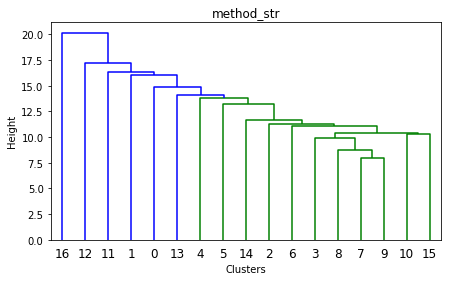

Number of clusters 2
Cophenet score is 0.956333


In [38]:
doHierarchialClustering(dtm,'euclidean',threshold=20)

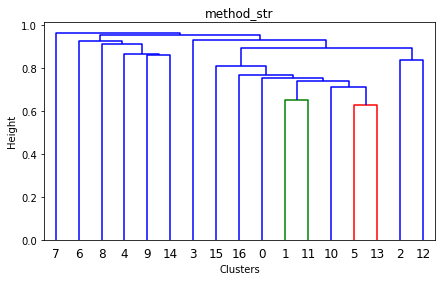

Number of clusters 7
Cophenet score is -0.235672


In [39]:
doHierarchialClustering(dtm,'cosine',threshold=.89)

* Learn about *Latent Dirichlet Allocation* to extract topics from your corpora, and measure each document on how much of each topic it contains. How do you interpret these topics?

Some **potential inspiration** below (but please keep your own story simple!):
* https://liferay.de.dariah.eu/tatom/topic_model_mallet.html covers a few examples of text analysis
* http://fantheory.viacom.com/
* https://pudding.cool/2017/02/vocabulary/

Additional resources on LDA (if you are interested): 
* https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d
* https://www.youtube.com/watch?v=DDq3OVp9dNA

[LDA Code](https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730)

[Grid Search LDA](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/)

In [28]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [29]:
n_components=2
# lda_model= LatentDirichletAllocation(n_topics=n_components, max_iter=5, learning_method='online',
#                                 learning_offset=50.,random_state=0,n_jobs=-1).fit(dtm)
lda_model = LatentDirichletAllocation(n_topics=2,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(dtm)

print(lda_model)  # Model attributes


# # Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(dtm))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(dtm))

/usr/local/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=2, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
Log Likelihood:  -4955014.817870218
Perplexity:  6304.490987922088


In [30]:
lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=2, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

__GridSearch the LDA Model to find best fit__

In [31]:
def GridSearchLDA(dtm):
    # Define Search Param
    search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm)
    return model

In [34]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
model = GridSearchLDA(dtm)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dtm))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -1801093.800076484
Model Perplexity:  6663.630677256372


In [35]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [36]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,beatles,gorilla,ritz,korman,champ,paul,brothers,dink,lugosi,beery,stevens,hogan,bela,ringo,kelly
Topic 1,henry,holmes,june,anais,miller,sherlock,clare,washington,nin,erotic,bana,traveler,watson,romanian,thurman
Topic 2,douglas,powell,pesci,vinny,shields,chuck,fred,moustache,columbo,jonathan,tomei,kirk,norris,cousin,dick
Topic 3,rogers,egyptian,emil,ginger,valentino,match,garner,ferrari,deaf,gavras,johnson,sheik,dove,stooges,lonesome
Topic 4,lee,yee,kitano,station,tony,lust,sisko,caution,ember,ang,japanese,tang,leung,wang,mayor
Topic 5,sharpe,lenzi,acerola,laranjinha,vood,ajith,vishnu,betti,silva,naples,varalaru,ace,cunha,ela,rifle
Topic 6,beast,disney,belle,fly,beauty,seth,goldblum,cronenberg,hercules,animated,brundle,castle,gaston,maurice,davis
Topic 7,romero,political,flynn,chong,annabel,salvador,potter,argentina,archbishop,arnaz,teachers,fiennes,monica,roderick,gamera
Topic 8,time,story,like,people,just,great,love,really,life,characters,character,best,good,films,family
Topic 9,like,good,just,time,really,story,great,make,don,bad,way,movies,plot,people,does


__Interpreting Topic Modeling output__
 - Looking at the top 15 words per topic, it closely resembles genres
  - Topic 0 - Song titles/Artistes
  - Topic 1 - Thriller Action Movies
  - Topic 4 - Asian Movies
  - The rest wasnt clear to me

### Normalize your bags
In the above exercise, you may find it important to normalize your data.  One useful method when dealing with text is *Term Frequency - Inverse Document Frequency (TF-IDF)*. You can see more detail on this here: http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/.

Once you understand the concept, **express your data as TF-IDF vectors (instead of simple bag-of-words counts), and see if it changes your above story**. 

In [37]:
dtm_tfid = TfidfTransformer().fit_transform(dtm)
dtm_tfid = dtm_tfid.toarray() 

In [38]:
df=pd.DataFrame(dtm_tfid, columns=vocab)
df[vocab[0:20]].head()

,aaa,aaah,aahed,aames,aaron,aazmi,aback,abaddon,abandon,abandoned,abandoning,abandonment,abandons,abaskharon,abattoir,abbas,abbey,abbie,abbott,abbreviated
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
del df

In [40]:
getFrequentWord(dtm_tfid)

Most frequent word: like


In [41]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
model = GridSearchLDA(dtm_tfid)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dtm))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -175736.99747983975
Model Perplexity:  9016.576452889705


In [42]:
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,laali,priya,namaga,blokey,tvand,larrikin,siam,buffoonery,batman,drake,writing,backfire,friels,just,way
Topic 1,neutrality,tryed,edeid,zaky,gendy,nabeela,micol,morrow,feldman,marcos,time,georgio,cobbs,alex,good
Topic 2,colombo,diagnosis,racketeers,againist,shotten,incommunicability,sabbaththemovie,decreased,digressions,livid,speckle,andelman,dubiety,flutters,earnestly
Topic 3,appetizing,suburbanite,brightens,coz,inhaling,lauderdale,appetit,longstocking,panflute,cheesiest,pippi,wallower,dragomir,psychodynamics,walrus
Topic 4,nesmith,ottola,blooper,topcoat,tufted,stucco,lancelot,mademoiselle,portals,accrues,inexexplicably,aestheticians,maple,aficianados,unpainted
Topic 5,justin,kanew,congo,cosovo,wether,bosnia,economical,albania,solanas,institutional,argentinian,brault,montr,nastassja,canada
Topic 6,mulroney,primed,dissects,reassess,dermor,maris,garner,peggy,play,just,fox,love,sunday,ann,like
Topic 7,platforms,enfield,spanking,adrianna,sdfm,zentradi,hancock,kawamori,swart,dialoge,diver,soave,programa,lilja,anjos
Topic 8,like,good,just,great,story,really,time,people,movies,don,love,watch,think,best,films
Topic 9,aparent,mcgurney,storylines,angelle,aparante,commanders,miscreant,motivo,incisive,leukaemia,commandment,pawnee,paricularly,pinkett,jada


### Show us your bags (Version 2)

Show and explain what one of your documents looks like as a TF-IDF vector below.  How is this different from a simple bag-of-words?

__Explain the differences after running this in the cluster__

# Chapter 2: Simple Supervised Learning with Text
Now that you are comfortable with treating text as numbers, we can try out supervised learning.  We'll use a labelled dataset of IMDB reviews to classify each review as 'positive' or 'negative'.  You can **find the data below:**

http://ai.stanford.edu/~amaas/data/sentiment/

Load in and process the data, then train a supervised learning model.  **You should achieve val or test set accuracy of 85%**. Pretty good for a simple bag, no?

In [78]:

reviews_train = load_files("aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target

print("Number of documents in train data: {}".format(len(text_train)))
print("Samples per class (train): {}".format(np.bincount(y_train)))

reviews_test = load_files("aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target

print("Number of documents in test data: {}".format(len(text_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))

Number of documents in train data: 25000
Samples per class (train): [12500 12500]
Number of documents in test data: 25000
Samples per class (test): [12500 12500]


In [79]:
vect = CountVectorizer(min_df=5, ngram_range=(2, 2))
X_train = vect.fit(text_train).transform(text_train)
X_test = vect.transform(text_test)

print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("X_train:\n{}".format(repr(X_train)))
print("X_test: \n{}".format(repr(X_test)))

feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Vocabulary size: 129549
X_train:
<25000x129549 sparse matrix of type '<class 'numpy.int64'>'
	with 3607330 stored elements in Compressed Sparse Row format>
X_test: 
<25000x129549 sparse matrix of type '<class 'numpy.int64'>'
	with 3392376 stored elements in Compressed Sparse Row format>
Number of features: 129549


In [84]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

/home/hanifa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best cross-validation score: 0.88
Best parameters:  {'C': 1}
Best estimator:  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [85]:
lr = grid.best_estimator_
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Score: {:.2f}".format(lr.score(X_test, y_test)))

/home/hanifa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score: 0.88


# Chapter 3: Playing with Recurrent Neural Networks (RNN)
So far, we've only treated text as a simple bag, with reasonable results.  We'll now shift to a more complex representation of language: recurrent neural networks.  To do so, we need to process text at the word or character level, and capture the sequence of a document. 

Our task here is to build an RNN that 'eats up' sequences of characters in order to predict the next character in a sequence, for every step in the sequence of a document. This is a common (and fun) task, with lots of examples available online. 

For this task, use existing RNN APIs (don't code everything from scratch) from Keras or PyTorch. 

**Read up on RNNs and this exercise** below:
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/ - start here!
* https://github.com/martin-gorner/tensorflow-rnn-shakespeare - video, slides and code going through an example with Shakespeare
* http://killianlevacher.github.io/blog/posts/post-2016-03-01/post.html - another nice example based on Trump tweets

### Prepare your data

Our first step is to prepare our text. **Process your corpora into a format that can be used by an RNN, and walkthough one sequence below**.

An **example way to shape your data** for this task is as follows (feel free to play around with different structures):

*In this example your corpora starts with the string 'the cat and I'*
* RNN input: divide your text into sequences of 10 characters e.g. 'the cat an'
* RNN output: the 1 character immediately following RNN input sequences e.g. 'd'. 
* Note: You may or may not want to divide your text into overlapping strings (e.g. RNN input contains 'the cat an', 'he cat and', 'e cat and ', ...) . How is the model different in each case?
* Note: Your 'vocabulary' or `vocab_size` here is the number of unique characters in your text (and therefore the number of classes you want to predict)

In [43]:
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

Using TensorFlow backend.


606208/600901 [==============================] - 0s 1us/step
Corpus length: 600893


In [44]:
# Length of extracted character sequences
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


In [45]:
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [46]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [47]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
import random
import sys

for epoch in range(1, 60):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    model.fit(x, y,
              batch_size=128,
              epochs=1)

    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text + '"')

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
Epoch 1/1
200278/200278 [==============================] - 154s 770us/step - loss: 1.9992
--- Generating with seed: "ecome
strong enough, hard enough, artist enough.... piety, t"
------ temperature: 0.2
ecome
strong enough, hard enough, artist enough.... piety, the streng to the such a something and schopening to the world despaint to the such a present to the world and streally and schoues to the consideration and consideral and consideration of the such a soletion of the something to the exteration of the consideration of the some of the such a something the world in the pressions of the streng to the may to the such a despression of the soul and the co
------ temperature: 0.5
 to the may to the such a despression of the soul and the consistains to the a religious to his hand the exament of the way streng and the sous simpling the german the means to be existiment to the indection of comparence for the saims of the would consernal far the sechily in the a putainty of the seet

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


as in the proticeness of themself and philosophy. that what it is
------ temperature: 1.0
 the proticeness of themself and philosophy. that what it is
dispese the cisestoment--as
our ages of put the cifemination of
philosophy willu infectfoonarious
ratherly
indispress
when betan his olderman vider these mean has intentionalization, command in that, in a rable and, he
is no learn bundupousny enjoys, as may for thing-hi. there is his detenration in through among the truth, the masce-hunce
of like the ider and granuring and resunards and chille th
------ temperature: 1.2
e
of like the ider and granuring and resunards and chille therefoaten and the dall. novelo
atfaccrusum or god," to
who yet that too and
mind the believent of
leaihed. over to its value the from the
unuponsed distinctivat uponer say,
even backhedes,
the
truth clasm ou
opiral"--as are seurt to may unde
all--higs of centartery thereflequality,
amten and orient though as laim,  being in all thues love you cause said lights
er

### Generate text

Once the model is trained, we can use it to generate completely new text in the style of your training data.  **Train a model using your original choice of corpus below, and generate some sample sentences.** Don't worry too much about your loss / accuracy during training, but instead check on the text your model is generating. Your generated text should be somewhat coherent, i.e. similar to your training text in structure, and not excessively mispelled.

An **example model architecture** is as follows (feel free to play around with different structures):
* Embedding (for each character in your vocab) of dimension 64
* Dropout of 20% for the embedding input to the RNN
* 2 LSTM layers, each of dimension 512 (play around with the number and dimension of hidden layers)
* Dropout of 50% for each LSTM layer
* Dense softmax layer of same dimension as your vocab size (e.g. if your vocab size is 100, this layer is the probabilty that your output is one of 100 possible characters)
    
**You should understand what each of the above elements are and how they work at a high level by the end of this week's exercise.**

### Generalizing the exercise
How do you think you can apply what you learned in the above exercise to other problems involving text? For example, how would you tackle the previous IMDB sentiment classification task using an RNN architecture? **Discuss below.**

(*Bonus*: create an RNN model for the IMDB classification task and discuss your results. How does the performance compare to your bag of words model?)

# Chapter 4: RNNs from scratch
Now that you understand how to use RNNs, it's time to build a basic one from scratch.  You won't understand how they work until you get stuck in the weeds! 

### Generate text (Version 2)
Your task is now to **build the forward pass of a simple RNN, without using any existing RNN APIs**. You can use PyTorch or Tensorflow (Keras is too high level for this exercise), both of which will automatically handle backpropagation for you.  If you use Tensorflow, please research and use Eager execution - it replaces Tensorflow's default graph / session framework, which is very difficult to learn and debug.

Similar to last week's exercise, create a class for your network (write forward and loss steps, allowing PyTorch or Tensorflow to handle backpropagation for you).  Consider appropriate sizes for your input, hidden and output layers - your __init__ method should take in the params `hidden_size`, `vocab_size`, and `embedding_size` (if you use embeddings). Using these variables, you should initialise three weight layers `input_layer`, `hidden_layer`, and `output_layer`.  In an RNN, you will also have to deal with another item - the `hidden_state`. (Note: your RNN structure may vary slightly from this depending on your learning materials, but the key part is always `hidden_state`)

You should **train your RNN on the same data and task as in Chapter 3.**

**How do the results of your basic RNN compare to your model in Chapter 3?**  What do you think explains the difference in performance? Discuss below.

Some relevant resources on LSTMs (and RNN theory) below if you are interested:
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://www.youtube.com/watch?v=93rzMHtYT_0&list=LLpNVCNE9cYqVrjb2O8bZUGg&index=2&t=0s
* https://www.youtube.com/watch?v=zQxm3Upr3_I
* http://harinisuresh.com/2016/10/09/lstms/

### Bonus Challenges (not required!):
1. Build the forward pass of an LSTM, without using any existing RNN APIs (as above, with PyTorch or Tensorflow)
1. Build a basic RNN or LSTM in Numpy - including forward pass as well as backpropogation